<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-libraries" data-toc-modified-id="Load-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries</a></span></li><li><span><a href="#Split-articles-into-sentences" data-toc-modified-id="Split-articles-into-sentences-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Split articles into sentences</a></span></li><li><span><a href="#Split-audio-files-into-sentences" data-toc-modified-id="Split-audio-files-into-sentences-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Split audio files into sentences</a></span></li><li><span><a href="#Make-pairs-of-audio" data-toc-modified-id="Make-pairs-of-audio-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Make pairs of audio</a></span></li></ul></div>

# Load libraries

In [1]:
import os
import librosa
import IPython.display as ipd
import pysrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random

# Split articles into sentences

In [2]:
data_dir = "./data/"

In [221]:
articles = []

for article_file in next(os.walk(data_dir + "article/"))[2]:
    with open(data_dir + "article/" + article_file, encoding='utf-8') as f:
        article = f.read()
        articles.append(article.split('. '))

In [222]:
articles[6]

['Bốn trăm người đăng ký thử nghiệm vaccine Covivac HÀ NỘI',
 'Tính đến 15h chiều 5/3, có 400 người đăng ký thử nghiệm Covivac, vaccine Covid-19 thứ hai của Việt Nam, phần lớn đăng ký trực tuyến',
 'Một cán bộ thử nghiệm lâm sàng cho biết quá trình tuyển tình nguyện viên bắt đầu từ 8h sáng nay',
 'Có 2 hình thức đăng ký gồm trực tuyến qua điện thoại, website, email và trực tiếp tại tầng 5, nhà A1, Trường Đại học Y Hà Nội (HMU)',
 'Các bàn đăng ký trực tiếp mở tới 17h hàng ngày, còn hotline đăng ký trực tuyến sẵn sàng 24/24',
 'Điểm đăng ký trực tiếp tại HMU đón khoảng 5 người đến vào chiều 5/3, gồm hai nam thanh niên, một người trung niên và một phụ nữ',
 'Cán bộ y tế giải thích về quá trình thu tuyển, khám sàng lọc và quyền lợi của tình nguyện viên',
 'Họ lưu lại thông tin nếu người đăng ký có bệnh lý nền, điều kiện tuyển tình nguyện viên là không mang thai và tiêm vaccine khác trong suốt quá trình tham gia thử nghiệm đối với nữ',
 'Do ảnh hưởng của Covid-19, số lượng người đăng ký tr

In [223]:
import re

def remove_nonletter_and_lowercase(s):
    s = re.sub('\d+', ' ', s)
    s = re.sub('[\W]+', ' ', s.lower()).strip()
    return s

# Remove any non-word character and digit
for article in articles:
    for i in range(len(article)):
        article[i] = remove_nonletter_and_lowercase(article[i])

In [224]:
articles[6][1]

'tính đến h chiều có người đăng ký thử nghiệm covivac vaccine covid thứ hai của việt nam phần lớn đăng ký trực tuyến'

# Split audio files into sentences

In [3]:
SEARCH_WORD_RANGE = 15
ACCEPTED_MATCH_RATE_TEMP = 0.4
ACCEPTED_MATCH_RATE_SUB = 0.25

In [496]:
def group_subs_of_each_sentence(subs, sentences, verbose=False):
    sentences_start_idx = []
    i = 0
    for sentence in sentences:
        start_idx = None
        i_cur = i
        match_count = 0
        for word in sentence.split(' '):
            for j in range(i, min(i + SEARCH_WORD_RANGE, len(subs))):
                if remove_nonletter_and_lowercase(subs[j].text) == word:
                    match_count = match_count + 1
                    if start_idx is None:
                        start_idx = j
                    i = j + 1
                    break
        if (match_count / len(sentence.split(' ')) < ACCEPTED_MATCH_RATE_TEMP) \
        or (match_count / (i - i_cur) < ACCEPTED_MATCH_RATE_SUB):
            start_idx = None
            i = i_cur
        
        # Debug
        if verbose:
            if start_idx is None:
                print("'" + sentence + "' is missing after:", end='')
                if len(sentences_start_idx) > 0:
                    k = len(sentences_start_idx) - 1
                    while sentences_start_idx[k] is None:
                        k = k - 1

#                     k = 0
#                     while sentences_start_idx[k] is None:
#                         k = k + 1

                    for j in range(sentences_start_idx[k], i):
                        while k < len(sentences_start_idx) and sentences_start_idx[k] is None:
                            k = k + 1
                        if k < len(sentences_start_idx) and j == sentences_start_idx[k]:
                            print("'")
                            print("'", end='')
                            k = k + 1
                        print(subs[j].text, end=' ');
                print("'")
                print("")
        
        sentences_start_idx.append(start_idx)

    sentences_start_idx.append(len(subs))
    
    sentences_time = []
    for i in range(len(sentences_start_idx) - 1):
        if sentences_start_idx[i] is None:
            sentences_time.append((None, None))
            continue
            
        start_time = subs[sentences_start_idx[i]].start.to_time()
        j = i + 1
        while sentences_start_idx[j] is None:
            j = j + 1
        end_time = subs[sentences_start_idx[j] - 1].end.to_time()
        sentences_time.append((start_time, end_time))
        
    return sentences_time

In [497]:
group_subs_of_each_sentence(pysrt.open(data_dir + "audio/17021218_DoanDinhDung/01.srt"),
                           articles[0],
                           verbose=True)

'các đại biểu quốc hội trung quốc họp tại đại lễ đường nhân dân bắc kinh hôm ảnh afp' is missing after:'
'Hạ Bảo Long quan chức hàng đầu của Bắc Kinh phụ trách các vấn đề Hồng Công cho rằng cải tổ hệ bầu cử là rất cần thiết để đảm bảo chỉ những người yêu nước mới có quyền điều hành thành phố này '



[(datetime.time(0, 0, 1, 170000), datetime.time(0, 0, 5, 290000)),
 (datetime.time(0, 0, 6, 420000), datetime.time(0, 0, 14, 290000)),
 (datetime.time(0, 0, 14, 960000), datetime.time(0, 0, 21, 690000)),
 (datetime.time(0, 0, 22, 450000), datetime.time(0, 0, 39, 120000)),
 (datetime.time(0, 0, 40, 80000), datetime.time(0, 0, 53, 240000)),
 (None, None),
 (datetime.time(0, 0, 54, 520000), datetime.time(0, 1, 15, 690000)),
 (datetime.time(0, 1, 17, 170000), datetime.time(0, 1, 23, 100000)),
 (datetime.time(0, 1, 23, 940000), datetime.time(0, 1, 36, 660000)),
 (datetime.time(0, 1, 38, 770000), datetime.time(0, 1, 51, 180000)),
 (datetime.time(0, 1, 52, 40000), datetime.time(0, 2, 4, 650000)),
 (datetime.time(0, 2, 5, 540000), datetime.time(0, 2, 14, 760000)),
 (datetime.time(0, 2, 15, 820000), datetime.time(0, 2, 32, 240000)),
 (datetime.time(0, 2, 33, 900000), datetime.time(0, 2, 46, 400000)),
 (datetime.time(0, 2, 47, 120000), datetime.time(0, 3, 0, 680000)),
 (datetime.time(0, 3, 2, 68

In [636]:
student_audio_segments_dict = {}
audio_dir = data_dir + "audio/"
for student in next(os.walk(audio_dir))[1]:
    subscript_dir = audio_dir + student + "/"
    articles_audio_segments = []
    for file in next(os.walk(subscript_dir))[2]:
        if file.endswith(".srt"):
            article_id = int(file[0:2]) - 1
            audio_segment = group_subs_of_each_sentence(pysrt.open(subscript_dir + file),
                                                        articles[article_id])
            articles_audio_segments.append(audio_segment)
    student_audio_segments_dict[student] = articles_audio_segments

In [637]:
# Save to a file
pickle.dump(student_audio_segments_dict, open(data_dir + "speaker_audio_segments_dict.pkl", 'wb'))

In [4]:
with open(data_dir + "speaker_audio_segments_dict.pkl", 'rb') as f:
    student_audio_segments_dict = pickle.load(f)

In [5]:
import datetime
def datetime_time_to_seconds(time):
    return time.hour * 3600 + time.minute * 60 + time.second + time.microsecond / 1000000

datetime_time_to_seconds(datetime.time(0, 0, 1, 170000))

1.17

In [526]:
DEFAULT_SAMPLING_RATE = 22050

def extract_segments_from_audio(audio_file_path, intervals):
    segments = []
    sample, sr = librosa.load(audio_file_path)
    for interval in intervals:
        if interval[0] is None or interval[1] is None:
            segments.append(None)
            continue
            
        start_idx = int(datetime_time_to_seconds(interval[0]) * sr)
        end_idx = int(datetime_time_to_seconds(interval[1]) * sr)
        segments.append(sample[start_idx:end_idx + 1])
    return segments

segments = extract_segments_from_audio(data_dir + "audio/17021218_DoanDinhDung/01.wav",
                                       student_audio_segments_dict['17021218_DoanDinhDung'][0])

# Let's try play an audio array
ipd.Audio(segments[1], rate=DEFAULT_SAMPLING_RATE)

In [640]:
# Save waveforms to files
for student in next(os.walk(audio_dir))[1]:
    subscript_dir = audio_dir + student + "/"
    for file in next(os.walk(subscript_dir))[2]:
        if file.endswith(".wav"):
            article_id = int(file[0:2]) - 1
            audio_segments = extract_segments_from_audio(subscript_dir + file,
                                                         student_audio_segments_dict[student][article_id])
            
            for i in range(len(audio_segments)):
                if audio_segments[i] is not None:
                    audio_data = np.asarray(audio_segments[i])
                    waveform_dir = data_dir + "waveform/" + student + "/" + file[0:2] + "/"
                    if not os.path.exists(waveform_dir):
                        os.makedirs(waveform_dir)
                        
                    np.save(waveform_dir + str(i) + ".npy", audio_data)

# Make pairs of audio

In [6]:
students_segments_indices = []
students = list(student_audio_segments_dict.keys())
for student in students:
    student_segments_indices = []
    for i in range(len(student_audio_segments_dict[student])):
        for j in range(len(student_audio_segments_dict[student][i])):
            if student_audio_segments_dict[student][i][j] == (None, None):
                student_segments_indices.append(None)
            else:
                student_segments_indices.append((i, j))
    students_segments_indices.append(student_segments_indices)

In [7]:
# Different speakers same sentence
DSSS_LEN = 20000

audio_pairs = []
for k in range(len(students_segments_indices[0])):
    for i in range(len(students_segments_indices)):
        for j in range(i + 1, len(students_segments_indices)):
            if students_segments_indices[i][k] is not None\
            and students_segments_indices[j][k] is not None:
                audio_info_1 = [students[i], students_segments_indices[i][k][0], students_segments_indices[i][k][1]]
                audio_info_2 = [students[j], students_segments_indices[j][k][0], students_segments_indices[j][k][1]]
                if random.randrange(2) == 1:
                    audio_info_1, audio_info_2 = audio_info_2, audio_info_1
                audio_pairs.append(audio_info_1 + audio_info_2)
random.shuffle(audio_pairs)
audio_pairs_dsss_df = pd.DataFrame(audio_pairs[:DSSS_LEN], columns=['student_I_id', 'article_I_id', 'sentence_I_id',
                                                                    'student_II_id', 'article_II_id', 'sentence_II_id'])
audio_pairs_dsss_df

,student_I_id,article_I_id,sentence_I_id,student_II_id,article_II_id,sentence_II_id
0,18021346_LocPhiTruong,2,8,17021284_LuuHoaiLinh,2,8
1,17021342_NhuAnhThu,1,0,17021275_VuQuocKhanh,1,0
2,18021113_NguyenThiMinhTam,0,6,17021283_DangNhatLinh,0,6
3,18020194_TrinhXuanBach,5,11,18020434_NguyenDangHa,5,11
4,17021312_PhamDacNgocNhat,8,12,17021321_TranThuPhuong,8,12
...,...,...,...,...,...,...
19995,18020290_NguyenTienDat,5,15,17021308_PhamHoangNam,5,15
19996,17021229_VuTrongDuong,2,43,17021321_TranThuPhuong,2,43
19997,17021338_LeVanThinh,7,11,18021002_NguyenTrungPhong,7,11
19998,18020710_NguyenQuocKhanh,5,17,17021357_TranQuangVinh,5,17


In [8]:
# Different speakers different sentences
DSDS_LEN = 10000

audio_pairs = []
for i1 in range(len(students_segments_indices)):
    for j1 in range(len(students_segments_indices[i1])):
        if students_segments_indices[i1][j1] is not None:
            audio_info_1 = [students[i1], students_segments_indices[i1][j1][0], students_segments_indices[i1][j1][1]]
            for i2 in range(i1 + 1, len(students_segments_indices)):
                for j2 in range(len(students_segments_indices[i2])):
                    if j1 != j2 and students_segments_indices[i2][j2] is not None:
                        audio_info_2 = [students[i2], students_segments_indices[i2][j2][0], students_segments_indices[i2][j2][1]]
                        if random.randrange(2) == 1:
                            audio_pairs.append(audio_info_1 + audio_info_2)
                        else:
                            audio_pairs.append(audio_info_2 + audio_info_1)
random.shuffle(audio_pairs)
audio_pairs_dsds_df = pd.DataFrame(audio_pairs[:DSDS_LEN], columns=['student_I_id', 'article_I_id', 'sentence_I_id',
                                                                    'student_II_id', 'article_II_id', 'sentence_II_id'])
audio_pairs_dsds_df

,student_I_id,article_I_id,sentence_I_id,student_II_id,article_II_id,sentence_II_id
0,17021242_PhamTuanHiep,8,8,18020434_NguyenDangHa,5,20
1,17021257_NguyenVietHoang,9,7,17021340_ThieuMinhThinh,5,7
2,17021324_NguyenHongQuan,2,12,17021284_LuuHoaiLinh,6,9
3,18020544_NguyenXuanHoang,2,42,17021214_TranVanCuong,1,16
4,18020544_NguyenXuanHoang,4,5,18021078_CongMinhSon,5,20
...,...,...,...,...,...,...
9995,18021027_LeThiPhuong,7,6,17021313_DinhCongPhan,7,17
9996,17021342_NhuAnhThu,7,8,18020106_NguyenQuocAn,2,14
9997,17021357_TranQuangVinh,0,13,17021343_NguyenVuongTien,8,6
9998,18021113_NguyenThiMinhTam,2,43,17021229_VuTrongDuong,6,3


In [9]:
# Same speakers different sentences
SSDS_LEN = 70000

audio_pairs = []
for k in range(len(students_segments_indices)):
    for i in range(len(students_segments_indices[k])):
        for j in range(i + 1, len(students_segments_indices[k])):
            if students_segments_indices[k][i] is not None\
            and students_segments_indices[k][j] is not None:
                audio_info_1 = [students[k], students_segments_indices[k][i][0], students_segments_indices[k][i][1]]
                audio_info_2 = [students[k], students_segments_indices[k][j][0], students_segments_indices[k][j][1]]
                if random.randrange(2) == 1:
                    audio_info_1, audio_info_2 = audio_info_2, audio_info_1
                audio_pairs.append(audio_info_1 + audio_info_2)
random.shuffle(audio_pairs)
audio_pairs_ssds_df = pd.DataFrame(audio_pairs[:SSDS_LEN], columns=['student_I_id', 'article_I_id', 'sentence_I_id',
                                                                    'student_II_id', 'article_II_id', 'sentence_II_id'])
audio_pairs_ssds_df

,student_I_id,article_I_id,sentence_I_id,student_II_id,article_II_id,sentence_II_id
0,17021326_NguyenTuanQuoc,0,9,17021326_NguyenTuanQuoc,5,8
1,17021357_TranQuangVinh,1,35,17021357_TranQuangVinh,7,20
2,17021296_MacDinhMinh,6,17,17021296_MacDinhMinh,7,15
3,17021321_TranThuPhuong,5,18,17021321_TranThuPhuong,0,19
4,18021078_CongMinhSon,7,17,18021078_CongMinhSon,2,32
...,...,...,...,...,...,...
69995,18021159_DoTrinhQuocThang,0,9,18021159_DoTrinhQuocThang,6,15
69996,18020907_MaiXuanMinh,5,1,18020907_MaiXuanMinh,5,2
69997,17021219_HaAnhDung,6,5,17021219_HaAnhDung,2,39
69998,18021206_HoVanThep,7,23,18021206_HoVanThep,9,16


In [10]:
audio_pairs_df = pd.concat([audio_pairs_dsss_df, audio_pairs_dsds_df, audio_pairs_ssds_df], ignore_index=True)
audio_pairs_df

,student_I_id,article_I_id,sentence_I_id,student_II_id,article_II_id,sentence_II_id
0,18021346_LocPhiTruong,2,8,17021284_LuuHoaiLinh,2,8
1,17021342_NhuAnhThu,1,0,17021275_VuQuocKhanh,1,0
2,18021113_NguyenThiMinhTam,0,6,17021283_DangNhatLinh,0,6
3,18020194_TrinhXuanBach,5,11,18020434_NguyenDangHa,5,11
4,17021312_PhamDacNgocNhat,8,12,17021321_TranThuPhuong,8,12
...,...,...,...,...,...,...
99995,18021159_DoTrinhQuocThang,0,9,18021159_DoTrinhQuocThang,6,15
99996,18020907_MaiXuanMinh,5,1,18020907_MaiXuanMinh,5,2
99997,17021219_HaAnhDung,6,5,17021219_HaAnhDung,2,39
99998,18021206_HoVanThep,7,23,18021206_HoVanThep,9,16


<AxesSubplot:title={'center':'Same speaker'}>

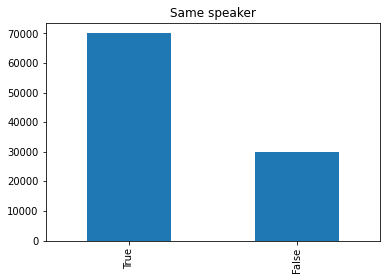

In [11]:
plt.title("Same speaker")
(audio_pairs_df['student_I_id'] == audio_pairs_df['student_II_id']).value_counts().plot.bar()

<AxesSubplot:title={'center':'Same sentence'}>

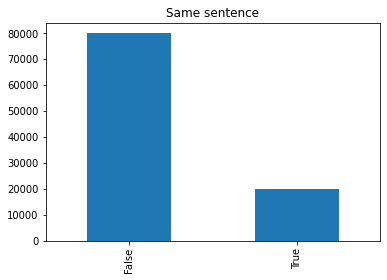

In [12]:
plt.title("Same sentence")
audio_pairs_df.apply(lambda row: (row['article_I_id'] == row['article_II_id'])\
                         and (row['sentence_I_id'] == row['sentence_II_id']), axis=1).value_counts().plot.bar()

In [13]:
# Number of tests per speaker
pd.concat([audio_pairs_df['student_I_id'], audio_pairs_df['student_II_id']], ignore_index=True).value_counts().describe()

count      57.00000
mean     3508.77193
std       198.11027
min      2919.00000
25%      3437.00000
50%      3581.00000
75%      3647.00000
max      3734.00000
dtype: float64

In [14]:
# Shuffle the dataframe rows
audio_pairs_df = audio_pairs_df.sample(frac=1).reset_index(drop=True)
audio_pairs_df

,student_I_id,article_I_id,sentence_I_id,student_II_id,article_II_id,sentence_II_id
0,17021218_DoanDinhDung,9,10,17021300_NguyenNgocMinh,9,10
1,17021296_MacDinhMinh,8,2,17021296_MacDinhMinh,1,9
2,17021308_PhamHoangNam,7,27,17021308_PhamHoangNam,1,3
3,17021297_NguyenDinhMinh,2,3,17021297_NguyenDinhMinh,8,10
4,17021325_NguyenMinhQuan,1,31,18020907_MaiXuanMinh,2,17
...,...,...,...,...,...,...
99995,18020889_DamTuanMinh,4,4,18020889_DamTuanMinh,0,10
99996,17021357_TranQuangVinh,2,0,17021357_TranQuangVinh,2,37
99997,18021027_LeThiPhuong,7,1,18021027_LeThiPhuong,3,1
99998,17021357_TranQuangVinh,0,6,17021357_TranQuangVinh,1,11


In [15]:
# Save to csv file
audio_pairs_df.to_csv(data_dir + "audio_sentence_pairs.csv", index=False)